#<b>Milestone 2

###<b>Loading libraries</b>

In [129]:
#!pip install tensorflow

In [128]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#import aws packages
import sagemaker
import boto3

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Let us load the data</b>

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [3]:
#buckets created manuallly in s3 and unzippped prior to this step
bucket = 'kdfdlkfasdklfjaslkdfjkalsdjfdasklflakdjflks'
train_dir = 'train' #prefix for the training directory

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

from sagemaker import get_execution_role
sagemaker_session = sagemaker.Session()
role = get_execution_role()
#print(role) - check role and change policy is getting access denied error

#set up the connection to s3 bucket
conn = boto3.client('s3') #limits to pulling 1,000 files, need multiple calls to API
paginator = conn.get_paginator('list_objects') #make multiple calls

#additional prefixes within the training directory
for folder_name in ['/parasitized/', '/uninfected/']:

    #initialize key list
    key_list = [ ]

    #Path of the folder
    contents = paginator.paginate(Bucket=bucket, Prefix=train_dir+folder_name).build_full_result()['Contents'] #extract list of images
    for f in contents:
        key_list.append(f['Key'])
    
    #access images from list, skip over first two keys which are "directories"
    #skipped over directories: 'unzipped/cell_images/train/', 'unzipped/cell_images/train/parasitized/'
    for i, key in enumerate(key_list):
        try:
            s3_object = conn.get_object(Bucket=bucket, Key=key)
            body = s3_object['Body']
            image = Image.open(body)
            image = image.resize((SIZE, SIZE))
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [4]:
#buckets created manuallly in s3 and unzippped prior to this step
bucket = 'kdfdlkfasdklfjaslkdfjkalsdjfdasklflakdjflks'
test_dir = 'test' #prefix for the training directory

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
test_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
test_labels = []

from sagemaker import get_execution_role
sagemaker_session = sagemaker.Session()
role = get_execution_role()
#print(role) - check role and change policy is getting access denied error

#set up the connection to s3 bucket
conn = boto3.client('s3') #limits to pulling 1,000 files, need multiple calls to API
paginator = conn.get_paginator('list_objects') #make multiple calls

#additional prefixes within the training directory
for folder_name in ['/parasitized/', '/uninfected/']:

    #initialize key list
    key_list = [ ]

    #Path of the folder
    contents = paginator.paginate(Bucket=bucket, Prefix=test_dir+folder_name).build_full_result()['Contents'] #extract list of images
    for f in contents:
        key_list.append(f['Key'])
    
    #access images from list, skip over first two keys which are "directories"
    #skipped over directories: 'unzipped/cell_images/train/', 'unzipped/cell_images/train/parasitized/'
    for i, key in enumerate(key_list):
        try:
            s3_object = conn.get_object(Bucket=bucket, Key=key)
            body = s3_object['Body']
            image = Image.open(body)
            image = image.resize((SIZE, SIZE))
            test_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

###<b>Normalize the images

In [5]:
train_images = (train_images/255).astype('float32')
test_images = (test_images/255).astype('float32')

As we have done our preprocessing required and performed some EDA to gain some insights in our Milestone-1 so now we will try to build our model and try evaluating its performance.

###<B>One Hot Encoding on the train and test labels

In [6]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)
# Similarly let us try to encode test labels
test_labels=to_categorical(test_labels,2)

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

####<b> Importing the required libraries

In [7]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the model

In [8]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

####<b> Compiling the model

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks 

In [10]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and train our Model

In [11]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history=model.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 14s 22ms/step - loss: 0.4124 - accuracy: 0.8081 - val_loss: 0.2427 - val_accuracy: 0.8988
Epoch 2/20
624/624 [==============================] - 13s 21ms/step - loss: 0.1199 - accuracy: 0.9546 - val_loss: 0.2421 - val_accuracy: 0.9269
Epoch 3/20
624/624 [==============================] - 14s 22ms/step - loss: 0.0927 - accuracy: 0.9680 - val_loss: 0.1285 - val_accuracy: 0.9692
Epoch 4/20
624/624 [==============================] - 13s 21ms/step - loss: 0.0747 - accuracy: 0.9754 - val_loss: 0.1034 - val_accuracy: 0.9760
Epoch 5/20
624/624 [==============================] - 13s 21ms/step - loss: 0.0702 - accuracy: 0.9764 - val_loss: 0.0971 - val_accuracy: 0.9802
Epoch 6/20
624/624 [==============================] - 13s 21ms/step - loss: 0.0678 - accuracy: 0.9777 - val_loss: 0.1051 - val_accuracy: 0.9742
Epoch 7/20
624/624 [==============================] - 13s 21ms/step - loss: 0.0623 - accuracy: 0.9796 - val_loss: 0.1072 - val_accuracy:

####<b> Evaluating the model on test data

In [12]:
accuracy = model.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 1s 6ms/step - loss: 0.0817 - accuracy: 0.9777

 Test_Accuracy:- 0.9776923060417175


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



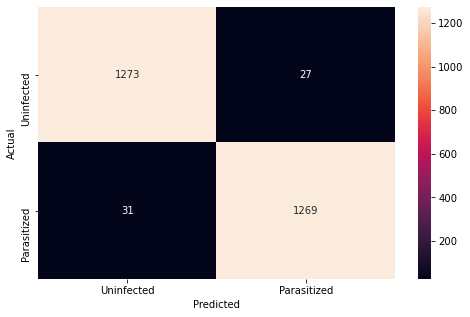

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

In [14]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

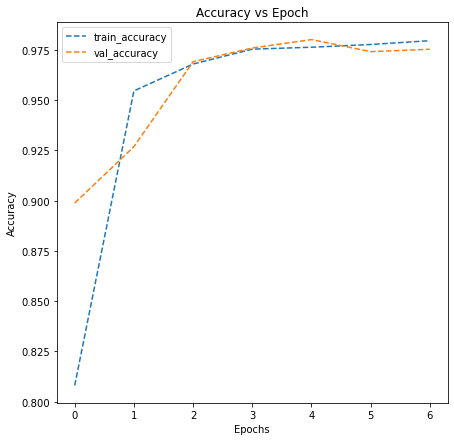

In [15]:
plot_accuracy(history)



* Here we can clearly observe that the training and valiation accuracy are increasing 
* And we can also notice that validation accuracy is slightly higher than the train accuracy

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [16]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model
    
    

In [114]:
#creating sequential model
model1=Sequential()

model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

model1.add(Flatten())

model1.add(Dense(512,activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(2,activation="softmax"))#2 represent output layer neurons 


model1.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_168 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_156 (Dropout)        (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 32, 32, 32)      

####<b> Compiling the model

The loss function of binary_crossentropy seemed reasonable, since we are aiming to classify cells into two categories (infected vs. uninfected). Selection of the loss function will be based on the type of classification task. RMSprop optimizer was selected; it uses the sign of the gradient to determine the extent to which to increase the step size. If the signs agree, then the step size is increased in updating the weights. This works with batches as compared to Rprop.
 
Documentation for loss functions: https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function 
Documentation for the optimizers: https://keras.io/api/optimizers/

In [115]:
#model2.compile(loss=tf.keras.losses.KLDivergence(reduction="auto", name="kl_divergence"), optimizer='RMSprop', metrics=['accuracy'])
model2.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

<b> Using Callbacks
 

In [116]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [117]:
history1=model2.fit(train_images,train_labels,batch_size=32,callbacks=callbacks, validation_split=0.2,epochs=30,verbose=1)

Epoch 1/30
624/624 [==============================] - 32s 50ms/step - loss: 0.3536 - accuracy: 0.8310 - val_loss: 0.1103 - val_accuracy: 0.9798
Epoch 2/30
624/624 [==============================] - 31s 50ms/step - loss: 0.0951 - accuracy: 0.9738 - val_loss: 0.1348 - val_accuracy: 0.9696
Epoch 3/30
624/624 [==============================] - 31s 49ms/step - loss: 0.0861 - accuracy: 0.9759 - val_loss: 0.0947 - val_accuracy: 0.9792
Epoch 4/30
624/624 [==============================] - 31s 50ms/step - loss: 0.0842 - accuracy: 0.9749 - val_loss: 0.0474 - val_accuracy: 0.9856
Epoch 5/30
624/624 [==============================] - 31s 50ms/step - loss: 0.0792 - accuracy: 0.9761 - val_loss: 0.1221 - val_accuracy: 0.9724
Epoch 6/30
624/624 [==============================] - 31s 49ms/step - loss: 0.0798 - accuracy: 0.9777 - val_loss: 0.0849 - val_accuracy: 0.9842
Epoch 7/30
624/624 [==============================] - 31s 49ms/step - loss: 0.0772 - accuracy: 0.9760 - val_loss: 0.1394 - val_accuracy:

####<b> Evaluating the model

In [118]:
accuracy1 = model2.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy1[1])

82/82 [==============================] - 1s 10ms/step - loss: 0.0886 - accuracy: 0.9792

 Test_Accuracy:- 0.9792307615280151


<b> Plotting the confusion matrix
    
The primary 
   

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1300
           1       0.97      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



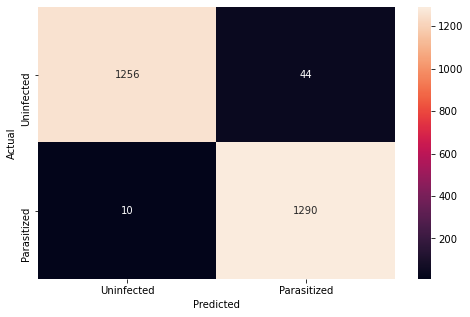

In [119]:
pred = model2.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

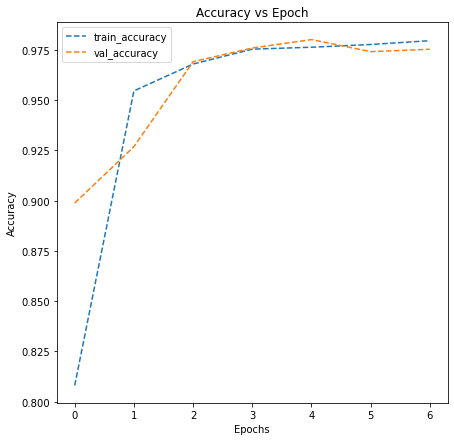

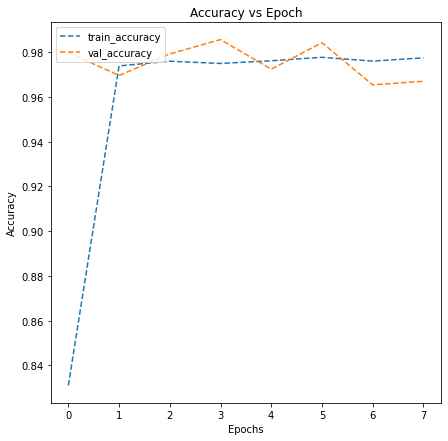

In [120]:
plot_accuracy(history)
plot_accuracy(history1)

####<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?

LeakyRelu is likely to improve the performance compared to the Relu activation function, since it allows a small, non-zero constant gradient to avoid the dying relu problem.

*  Can BatchNormalization improve our model?

Batch normalization may improve the model since the covariates may shift less numerically in the network between layers; this speeds up training and allows use of a higher learning rate.

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [125]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [127]:
model2 = Sequential()
model2.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), padding='same'))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU(),input_shape=(64,64,3)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(BatchNormalization())

model2.add(Flatten())

model2.add(BatchNormalization())
model2.add(Dense(512,activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(BatchNormalization())
model2.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

model2.summary()

NameError: name 'keras' is not defined

####<b>Compiling the model

In [122]:
model2.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

<b> Using callbacks

In [123]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and train the model

In [124]:
history2 = model2.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=30,verbose=1)

Epoch 1/30
 79/624 [==>...........................] - ETA: 1:15 - loss: 0.7534 - accuracy: 0.6634

KeyboardInterrupt: 

<b>Plotting the train and validation accuracy

In [ ]:
# plotting the accuracies


####<b>Evaluating the model

In [ ]:
# Evaluate the model to calculate the accuracy
accuracy = model2.evaluate(________, ______________, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

#####<b>Observations and insights: ____

<b> Generate the classification report and confusion matrix 

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model2.predict(_______)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(________________,axis = 1)
#Printing the classification report
print(classification_report(______,_______))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(_____,_____)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [ ]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Using image data generator

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images

train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                  zoom_range = 0.5, rotation_range=30)
val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = _______, y = __________, batch_size=64, seed=42, shuffle=True)     

# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x= _________, y = _________, batch_size=64, seed=42, shuffle=True)

####**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

In [ ]:
#Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

#Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

#####<b>Observations and insights: ____

####<b>Building the Model

In [ ]:
model3 = Sequential()

# Build the model here

# use this as the optimizer
adam = optimizers.Adam(learning_rate=0.001)

model3.compile(loss=________________, optimizer=adam, metrics = ['accuracy'])
model3.summary()

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and Train the model

In [ ]:
history3 = model3.fit(train_generator, 
                                  validation_data=val_generator,
                                  batch_size=_____,callbacks=___________,
                                  epochs=20,verbose=1)

####<B>Evaluating the model

<b>Plot the train and validation accuracy

In [ ]:
# plotting the accuracies
plot_accuracy(_________)

In [ ]:
# Evaluating the model on test data
accuracy3 = _________.evaluate(________, ___________, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy3[1])

<B>Plotting the classification report and confusion matrix

<b> Now let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**

In [ ]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top=_________, weights='imagenet', input_shape=(64,64,3))
vgg.summary()

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False

# Add classification layers on top of it  
 
x = Flatten()(transfer_layer.output) #Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation='relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dropout(0.3)(x)

# Add a dense layer with 64 neurons

x = BatchNormalization()(x)
pred = Dense(______, activation='softmax')(_____)

model4 = Model(vgg.input, pred) #Initializing the model

####<b>Compiling the model

In [ ]:
# Compiling the model 

<b> using callbacks

In [ ]:
# Adding Callbacks to the model

<b>Fit and Train the model

In [ ]:
#Fitting the model and running the model for 10 epochs
history4 = model4.fit(
            __________, ______________,
            epochs=_________,
            callbacks=_____________,
            batch_size=_________,
            validation_split=0.2,
            verbose=1
)

<b>Plot the train and validation accuracy

In [ ]:
# plotting the accuracies
plot_accuracy(__________)

#####**Observations and insights: _____**

*   What can be observed from the validation and train curves?

####<b> Evaluating the model

In [ ]:
# Evaluating the model on test data


<b>Plotting the classification report and confusion matrix

In [ ]:
# Plot the confusion matrix and generate a classification report for the model

####<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choosw the model with the best accuracy scores from all the above models and save it as a final model.


###<b> Observations and Conclusions drawn from the final model: _____



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?